# Extracción de datos

## Importar librerías

In [ ]:
!pip install selenium webdriver-manager --quiet

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
def set_up_driver():
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')

    # Configure driver path
    service = Service('/usr/bin/chromedriver')
    driver = webdriver.Chrome(options=chrome_options)
    return driver

In [ ]:
def scrapper(driver, url : str, by : str, selector : str, wait: bool = False,get_childrens: bool = False):
  try:
    driver.get(url)
    if wait == True or get_childrens == True:
      childrends = WebDriverWait(driver, 3).until(
          EC.presence_of_all_elements_located((by, selector))
      )
    if get_childrens:
      return childrends
    else:
      data = driver.find_element(by, selector)
    return data
  except Exception as e:
    print(f"Error scraping page: {e}")
    return []

## Scrapping credits

Hacemos scraping de los créditos del juego, guardando información sobre relaciones del juego en un diccionario.

In [ ]:
!pip install beautifulsoup4 --quiet

In [ ]:
import bs4
from bs4 import Comment
from bs4 import BeautifulSoup

url = "https://boardgamegeek.com/boardgame/265736/tiny-towns/credits"
credits = {}
driver = set_up_driver()
div_credits = scrapper(driver,url,By.XPATH,"//div[@class='global-body-content-primary ng-scope']").get_attribute("innerHTML")
soup = bs4.BeautifulSoup(div_credits, "html.parser")
li_credits = soup.find_all("li")

for li in li_credits:
  childs = []
  title = li.find("span")
  content = li.find("div",{'class':'outline-item-description'})
  a_content = content.find_all("a")

  if a_content is not None:
      for a in a_content:
        nombre = a.text.strip()
        driver_a = set_up_driver()
        href = a.get('href')
        url = "https://boardgamegeek.com"+href
        driver_a.get(url)
        soup = BeautifulSoup(driver_a.page_source, 'html.parser')
        # Obtenemos los 6 juegos más populares según bgg.
        mejores_juegos = [name.text.strip() for name in soup.find_all('h3', class_='rec-title ng-binding')]
        # Extraemos descripción
        descripcion = scrapper(driver_a,url,By.XPATH,"//article[@class='game-description-body']",True).text.strip()
        driver_a.close()
        childs.append((nombre,descripcion,mejores_juegos))

  div_content = content.find_all("div",{'class':'ng-binding ng-scope'})
  if div_content is not None:
    for div in div_content:
      childs.append(div.text.strip())

  if not div_content and not a_content:
    childs.append(content.text.strip())
  credits[title.text.strip()] = childs
credits

{'Primary Name': ['Tiny Towns'],
 'Alternate Names': ['Městečka na dlani',
  'Miasteczka',
  'Les Petites Bourgades',
  'Крихітні Містечка',
  'Крошечные города',
  'มหานครย่อส่วน',
  'タイニータウン',
  '小小城鎮',
  '타이니 타운'],
 'Year Released': ['2019'],
 'Designer': [('Peter McPherson',
   'Peter McPherson is a game designer and freelance writer from Upstate New York. His games include Tiny Towns, Wormholes, and Fit to Print.',
   ['Tiny Towns',
    'Fit to Print',
    'Wormholes',
    'Tiny Towns: Fortune',
    'Tiny Towns: Villagers',
    'Tiny Towns: Tiny Trees'])],
 'Solo Designer': ['N/A'],
 'Artists': [('Gong Studios',
   'From website:\nGong Studios is a 2D art outsourcing studio located in Depok, Indonesia. Established in 2010, we specialize in providing art for games, especially mobile, browser, and social games.',
   ["Aeon's End",
    "Aeon's End: War Eternal",
    'Clash of Cultures: Monumental Edition',
    "Aeon's End: The New Age",
    'Tiny Towns',
    'Fields of Green']),
  ('

In [ ]:
import csv

# Nombre del archivo CSV de salida
csv_file = 'creditos_relaciones.csv'

# Escribimos al archivo CSV
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Encabezado del CSV
    writer.writerow(['Sujeto', 'Relación', 'Objeto'])

    for relation_key in credits.keys():
        credit_data = credits[relation_key]

        if credit_data == ['N/A']:
            continue  # Saltar entradas no disponibles

        for data in credit_data:
            if isinstance(data, tuple):
                persona = data[0]
                descripcion = data[1]
                juegos_relacionados = data[2] if len(data) > 2 else []

                # Tripletas principales: Tiny Towns -> [relación] -> Persona
                writer.writerow(['Tiny Towns', relation_key, persona])

                # Descripción: Persona -> Descripcion -> [texto]
                writer.writerow([persona, 'Descripcion', descripcion])

                # Juegos relacionados: Persona -> Related Game -> [juego]
                for juego in juegos_relacionados:
                    writer.writerow([persona, 'Related Game', juego])
            else:
                # Para valores simples como strings (ej. Publisher)
                writer.writerow(['Tiny Towns', relation_key, data])

## Scraping estadisticas

Obtenemos primero los datos de la sección de estadísticas de BGG.

In [ ]:
def scrape_stats_section(url):
    """
    Extrae estadísticas de un juego desde una página web utilizando Selenium WebDriver.

    Parámetros:
    url (str): URL de la página del juego a scrapear

    Retorna:
    list: Lista de tuplas con las estadísticas y sus valores
    """
    driver = set_up_driver()
    items = scrapper(driver,url,By.CSS_SELECTOR, 'li.outline-item',get_childrens=True)
    resultados = []
    for item in items:
        try:
            stat = item.find_element(By.CSS_SELECTOR, 'div.outline-item-title').text.strip()
            valor = item.find_element(By.CSS_SELECTOR, 'div.outline-item-description a').text.strip()
            resultados.append((stat, valor))
        except Exception:
            continue
    return resultados


In [ ]:
import pandas as pd
stats = scrape_stats_section('https://boardgamegeek.com/boardgame/265736/tiny-towns/stats')
df = pd.DataFrame({"Title": [x[0] for x in stats], "Value": [x[1] for x in stats]})
df

,Title,Value
0,Avg. Rating,7.211
1,No. of Ratings,"20,747"
2,Weight,2.06 / 5
3,Comments,"3,037"
4,Fans,"1,019"
5,Overall Rank,462
6,Family Rank,121
7,All Time Plays,"96,528"
8,This Month,119
9,Own,"34,188"


Recopilamos los datos numéricos principales del juego en su panel de portada.

In [ ]:
def scrape_panel_stats(url):
    driver = set_up_driver()
    response = driver.get(url)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    metrics = soup.find_all('li', {"class":"gameplay-item"})

    # Number of players, official and community recommended
    off_players = metrics[0]
    off_players = off_players.text.strip().replace("\t", "").split(" ")[7]

    comm_players = soup.find('div', {"class": "gameplay-item-secondary"}).find_all('span')
    comm_players = comm_players[2].text.strip() + " " + comm_players[3].text.strip()
    comm_players = comm_players.replace("\t", "")
    # Time of play
    est_time = metrics[1].text.strip().replace("\t", "")[10:]
    # Age, official and community recommended
    off_age = metrics[2].text.strip().replace("\t", "").split(" ")[6]

    comm_age = soup.find_all('div', {"class": "gameplay-item-secondary"})
    comm_age = comm_age[2].text.strip().replace("\t", "").split(" ")[1]
    # Difficulty
    # difficulty = "".join(metrics[3].text.strip().replace("\t", "").split(" ")[6:10])
    df = pd.DataFrame(columns=["Title", "Value"])
    df.loc[0] = ["Official number of players", off_players]
    df.loc[1] = ["Recommended number of players according to the community", comm_players]
    df.loc[2] = ["Estimated time of play", est_time]
    df.loc[3] = ["Official recommended age", off_age]
    df.loc[4] = ["Community recommended age", comm_age]

    return df

In [ ]:
url = "https://boardgamegeek.com/boardgame/265736/tiny-towns"
df_numerico = scrape_panel_stats(url)

df_numerico

,Title,Value
0,Official number of players,1–6
1,Recommended number of players according to the...,1–5 — Best: 3
2,Estimated time of play,45–60 Min Playing Time
3,Official recommended age,14+
4,Community recommended age,10+


Obtenemos los precios en cada tienda disponible.

In [ ]:
def scrape_shopping_section(url):
    driver = set_up_driver()
    response = driver.get(url)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    store_prices = soup.find('ul', {"class":"summary summary-condensed summary-border summary-sale"}).find_all('li', {"class":"summary-item summary-sale-item ng-scope"})
    df_prices = pd.DataFrame(columns=["Title", "Value"])
    for i in store_prices:
        words = i.text.strip().split(" ")
        df_prices.loc[len(df_prices)] = [f'Price on {" ".join(words[-3:])}', words[0] + " " + words[1] if words[0] == "from" else words[0]]
    return df_prices

In [ ]:
url = "https://boardgamegeek.com/boardgame/265736/tiny-towns/marketplace/stores"
df_prices = scrape_shopping_section(url)

df_prices

,Title,Value
0,Price on Amazon,$39.99
1,Price on Noble Knight Games,from $30.00
2,Price on Hobbies and Games,from C$56.99
3,Price on Boardtopia,from $39.99
4,Price on Miniature Market,from $23.99
5,Price on In Hat Inc,from $39.95
6,Price on Gamers Guild AZ,from $39.99


Obtenemos datos sobre las expansiones, en particular, la cantidad de expansiones existentes.

In [ ]:
def scrape_expansions_section(url):
    driver = set_up_driver()
    response = driver.get(url)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    count_div = soup.find("div", class_="panel-body-toolbar-count")

    strong_tags = count_div.find_all("strong")

    expansion_count = strong_tags[1].text.strip()
    return int(expansion_count)

In [ ]:
num_expansions = scrape_expansions_section("https://boardgamegeek.com/boardgame/265736/tiny-towns/expansions")

df_numerico.loc[-1] = ["Number of expansions", num_expansions]
df_numerico.index = df_numerico.index + 1
df_numerico = df_numerico.sort_index()
df_numerico

,Title,Value
0,Number of expansions,8
1,Official number of players,1–6
2,Recommended number of players according to the...,1–5 — Best: 3
3,Estimated time of play,45–60 Min Playing Time
4,Official recommended age,14+
5,Community recommended age,10+


Ahora, concatenamos todos estos datos para obtener nuestro df de estadísticas final.

In [ ]:
# concatenamos df y df_numerico
df_stats = pd.concat([df, df_numerico, df_prices], axis=0).reset_index(drop=True)
df_stats.loc[2,"Title"] = "Difficulty according to the community"
df_stats

,Title,Value
0,Avg. Rating,7.211
1,No. of Ratings,"20,747"
2,Difficulty according to the community,2.06 / 5
3,Comments,"3,037"
4,Fans,"1,019"
5,Overall Rank,462
6,Family Rank,121
7,All Time Plays,"96,528"
8,This Month,119
9,Own,"34,188"


Finalmente, lo guardamos en un archivo csv.

In [ ]:
df_stats.to_csv("estadisticas.csv", index=False)

## Scraping foro

Como estrategia para hacer scraping del foro, de manera tal que podamos conseguir la máxima cantidad de información y minimizar la redundancia, recorremos 4 categorías de alta relevancia en el mismo: "Review", "Reglas", "Strategy" y "Variants". Luego, tomamos los 10 posts mejor puntuados en cada una de estas. Así, obtendremos las mejores contribuciones de la comunidad sobre cada posible query que haya.

In [ ]:
def scrap_forums(game_url):
    options = Options()
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')

    driver = webdriver.Chrome(options=options)
    looping_driver = webdriver.Chrome(options=options)
    categories = []
    links = []
    titles = []
    conversations = []

    for i in [63,66,67,69]: # 63 = Reviews, 66 = Reglas, 67 = Strategy, 69 = Variants
        url = game_url + f"/forums/{i}?sort=hot"
        response = driver.get(url)

        # Parse the HTML content
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Find all the relevant list items
        items = soup.find_all('li', class_='summary-item ng-scope')

        # Extract category and link from each item
        for item in items[:10]:
            # Extract category
            category_tag = item.find('span', class_='summary-item-tag')
            category = category_tag.get_text(strip=True)

            # Extract link
            link_tag = item.find('a', href=True)
            link = "https://boardgamegeek.com" + link_tag['href']

            title_element = item.find('h3', class_='m-0 fs-md text-semibold leading-inherit text-inline').find('a')
            title = title_element.text.strip()

            # Visitar cada link y extraer texto
            thread_response = looping_driver.get(link)
            WebDriverWait(looping_driver, 300).until(EC.presence_of_all_elements_located((By.TAG_NAME, 'gg-markup-safe-html')))
            thread_soup = BeautifulSoup(looping_driver.page_source, 'html.parser')
            conversation_elements = thread_soup.find_all('gg-markup-safe-html')

            # Visit each link and extract the conversation content
            conversation = "Title: " + title + "\nOriginal post: "

            response_num = 1
            conversation += conversation_elements[0].text.strip() + "\n"
            for conversation_element in conversation_elements[1:]:
                conversation += "Response number " + str(response_num) + ":\n" + conversation_element.text.strip() + "\n"
                response_num += 1
            # Append to lists
            categories.append(category)
            links.append(link)
            conversations.append(conversation)

    driver.close()
    # Create a pandas DataFrame
    df = pd.DataFrame({
        'Category': categories,
        'Link to Post': links,
        'Conversation': conversations
    })
    return df
df_foros_bgg = scrap_forums("https://boardgamegeek.com/boardgame/265736/tiny-towns")


In [ ]:
df_foros_bgg["Category"].value_counts()

,count
Category,
Reviews,10
Rules,10
Variants,10
Strategy,6


In [ ]:
df_foros_bgg.to_csv("df_foros_bgg.csv", index=False)

## Reseñas

Leemos reseñas de Tiny Towns en la web, y las guardamos en archivos .txt.

### Review BGG

In [ ]:
!pip install markdownify --quiet

In [ ]:
from markdownify import markdownify as md
def scrape_game_tutorial(url : str,by : str, selector : str):
    """
    Extrae el contenido de texto de un tutorial de juego desde una URL específica.

    Parámetros:
    url (str): La URL del tutorial del juego a extraer.

    Retorna:
    str: Texto limpio extraído de los elementos con selector CSS 'gg-markup-safe-html',
         o un texto vacío si ocurre un error.
    """
    driver = set_up_driver()
    elementos = scrapper(driver, url, by,selector, get_childrens= True)
    elements = ["<div>"]

    for elemento in elementos:
        elements.append(elemento.get_attribute("innerHTML"))
    elements.append("</div>")
    markdown_format = md("".join(elements))
    return markdown_format

In [ ]:
review_bgg = scrape_game_tutorial("https://boardgamegeek.com/thread/3369871/resena-de-tiny-towns",By.CSS_SELECTOR, 'gg-markup-safe-html')
print(review_bgg)
with open("review_bgg.txt", "w") as f:
    f.write(review_bgg)

¡Ah, los juegos de mesa! Solían ser los mismos de siempre, ¿verdad? Monopoly, Clue – divertidos por un tiempo, pero luego… meh. Luego llegó Carcassonne. Ese juego fue la droga de entrada, el que me mostró que los juegos de mesa podían ser más que solo tirar dados sin pensar. Pero no fue hasta que entré a Millennium Games (mi tienda local) que me di cuenta de lo PROFUNDO que era el agujero del conejo.  
  
Imagina esto: ¡una tienda dedicada completamente a los juegos de mesa! Paredes llenas de cajas, desbordando posibilidades. Aventuras cooperativas para el trabajo en equipo, batallas épicas por la gloria, mundos fantásticos que suplicaban ser explorados. Era abrumador de la mejor manera posible. Aquí estaba yo, un novato en juegos de mesa, rodeado de un universo que nunca supe que existía.  
  
Sintiendo un poco de confusión, un amable empleado de la tienda vino al rescate. Olvídate de los discursos de ventas, esta persona realmente quería ayudarnos a encontrar un juego que amaríamos. 

### Review externa

In [ ]:
link = "https://misutmeeple.com/2020/03/resena-tiny-towns/"

driver = set_up_driver()
response = driver.get(link)
soup = BeautifulSoup(driver.page_source, 'html.parser')


header = soup.find('h1')
review_externa = "Título:" + header.text
primer_titulo = soup.find('h2')
next_sibling = primer_titulo.next_sibling
while next_sibling:
    if next_sibling.name == 'h2':
        review_externa += "\nSección: "
    elif next_sibling.name == 'h3':
        review_externa += "\nSubsección: "
    elif next_sibling.name == 'ul':
        elementos = next_sibling.find_all('li')
        for li in elementos:
            review_externa += li.text + "\n"
        next_sibling = next_sibling.next_sibling
        continue
    elif len(next_sibling.text.strip().split(" ")) <= 1:
        next_sibling = next_sibling.next_sibling
        continue
    review_externa += next_sibling.text.strip() + "\n"
    next_sibling = next_sibling.next_sibling

print(review_externa[800:])

with open("review_externa.txt", "w") as f:
    f.write(review_externa)

 Arrakis Games (existe dependencia del idioma en las cartas, además del reglamento). Permite partidas de 1 a 6 jugadores, con una edad mínima sugerida de 14 años y una duración aproximada de entre 45 minutos. El precio de venta al público es de 39,95€. Para esta reseña se ha utilizado una copia de la versión en español de Arrakis Games.
Importante: si ya conoces el juego y/o sólo te interesa mi opinión sobre el mismo, puedes pasar directamente al apartado de Opinión. Los apartados Contenido y Mecánica están destinados especialmente a aquellos que no conocen el juego y prefieren hacerse una idea general de cómo funciona.
Ir a la Opinión Personal

Sección: Contenido
Dentro de una caja de cartón de dos piezas (tapa y fondo), de dimensiones 29,7×29,7×7,2 cm. (caja cuadrada estándar tipo Ticket to Ride), nos encontramos con los siguientes elementos:
6 Tableros de Jugador (de cartón)
40 Cartas Grandes (70×120 mm.):
25 Cartas de Edificio
15 Cartas de Monumento

25 Cartas de Edificio
15 Cartas

### Review de usuarios

In [ ]:
driver = set_up_driver()

base_url = "https://boardgamegeek.com/boardgame/265736/tiny-towns/ratings"
total_needed = 500  # Cambia esto según cuántas reseñas quieres
collected = 0
pageid = 1

banderas_validas = [
    "United States Flag",
    "Canada Flag",
    "United Kingdom Flag"
]

resultados = []

while collected < total_needed:
    url = f"{base_url}?pageid={pageid}&comment=1" if pageid > 1 else base_url
    print(f'Cargando página {pageid}...')
    driver.get(url)
    time.sleep(3)  # Ajusta según sea necesario

    # Encuentra todos los bloques de comentarios
    items = driver.find_elements(By.CSS_SELECTOR, 'li.summary-item.summary-rating-item')

    found_on_page = 0
    for item in items:
        try:
            # --- Comentario ---
            comentario_tag = item.find_element(By.CSS_SELECTOR, 'p.mb-0.ng-binding.ng-scope')
            comentario_texto = comentario_tag.get_attribute('innerText').strip()
            palabras = comentario_texto.split()
            if len(palabras) <= 10:
                continue

            # --- Bandera (país) ---
            try:
                bandera_img = item.find_element(By.CSS_SELECTOR, '.comment-header-location-flag img')
                bandera_alt = bandera_img.get_attribute('alt')
            except:
                bandera_alt = None

            if bandera_alt not in banderas_validas:
                continue

            # --- Rating ---
            try:
                rating_tag = item.find_element(By.CSS_SELECTOR, '.summary-item-callout .rating-angular')
                rating = rating_tag.text.strip()
            except:
                rating = None

            resultados.append({
                'puntaje': rating,
                'reseña': comentario_texto
            })
            collected += 1
            found_on_page += 1

            if collected >= total_needed:
                break
        except Exception as err:
            continue

    if found_on_page == 0:
        print("No se encontraron comentarios válidos en esta página, deteniendo la búsqueda.")
        break

    pageid += 1

# Crea el DataFrame
df = pd.DataFrame(resultados)
print(df.head())

In [ ]:
df.to_csv('../datos/estadisticas/reseñas_tiny_towns.csv', index = False)

## Scraping del manual

In [ ]:
!pip install pymupdf --quiet

Para obtener información del manual, descargamos el archivo PDF y luego extraemos el texto del mismo utilizando pymupdf.

In [ ]:
import pymupdf
def extract_text_from_pdf(pdf_path):
    """
    Extract plain text from a PDF file and store each page in a list.

    Args:
        pdf_path (str): Path to the PDF file

    Returns:
        list: List of extracted text from each page
    """
    text_contents = []
    try:
        # Open the PDF
        pdf_document = pymupdf.open(pdf_path)
        total_pages = len(pdf_document)
        # Extract text from each page
        for page_num in range(total_pages):
            page = pdf_document.load_page(page_num)
            # Extract plain text
            text = page.get_text("text")
            text_contents.append(text)

        pdf_document.close()
        return text_contents

    except Exception as e:
        print(f"Error extracting text from PDF: {e}")
        return []

def clean_text_manual(page_list):
    parsed_page_list = []
    for page in page_list:
        clean_text = re.sub(r'\n(?=[a-z])', ' ', page)
        clean_text = "\n".join(line for line in clean_text.split("\n") if len(line.strip()) > 1)
        parsed_page_list.append(clean_text)
    return parsed_page_list

In [ ]:
!pip install requests --quiet

In [ ]:
import re
import requests
url = "https://www.alderac.com/wp-content/uploads/2025/03/TinyTowns_Rulebook.pdf"

# Descargar el PDF
response = requests.get(url)
pdf_path = "reglas_juego.pdf"

# Guardamos el archivo localmente
with open(pdf_path, "wb") as f:
    f.write(response.content)

# Use the specific PDF path
pdf_path = "reglas_juego.pdf"

# Extract text and store in a list
pdf_pages = extract_text_from_pdf(pdf_path)

manual_pages = clean_text_manual(pdf_pages)
print(manual_pages[2][:400])
manual = "\n".join(manual_pages)

with open("manual.txt", "w") as f:
    f.write(manual)

Monuments
A monument is a special type of building that can  only be constructed by the player holding that card. 
Players may only construct their monuments once. 
Monuments may be constructed in any round, just like  a normal building (see Building Construction Rules). 
Upon constructing a monument, the player should read  the Monument card aloud, place it face-up in front  of them, and resolve 


## Videos de Tiny Town

In [ ]:
!pip install youtube_transcript_api --quiet

In [ ]:
from youtube_transcript_api import YouTubeTranscriptApi
def get_youtube_transcript(video_url, idioma):
    """
    Obtiene y procesa la transcripción de un video de YouTube.
    Parámetros:
    video_url (str): URL completa del video de YouTube
    idioma (str): Código de idioma de la transcripción deseada
    Retorna:
    str: Transcripción completa del video, o None si ocurre un error
    """
    try:
        # Extraer ID del video usando expresión regular
        video_id = re.findall(r'(?:v=|\/)([0-9A-Za-z_-]{11}).*', video_url)[0]

        # Obtener la transcripción en el idioma especificado
        transcript_list = YouTubeTranscriptApi.get_transcript(video_id, languages=(idioma,))

        # Combinar entradas de la transcripción
        return ' '.join(entrada['text'] for entrada in transcript_list)

    except Exception as e:
        print(f"Error al obtener la transcripción: {e}")
        return None

In [ ]:
video1 = get_youtube_transcript("https://www.youtube.com/watch?v=Ko6waVAt1CU", "nl") # neerlandés
video2 = get_youtube_transcript("https://www.youtube.com/watch?v=WGhZ83B4MoQ", "en") # inglés
video3 = get_youtube_transcript("https://www.youtube.com/watch?v=yF--uYWp0zw", "en")
video4 = get_youtube_transcript("https://www.youtube.com/watch?v=OyBCApqyUHg", "es")
# Guardamos en archivos
with open("video1.txt", "w") as f:
    f.write(video1)

with open("video2.txt", "w") as f:
    f.write(video2)

with open("video3.txt", "w") as f:
    f.write(video3)

with open("video4.txt", "w") as f:
    f.write(video4)

In [ ]:
video2[:2000]

"[Music] and now it's time for another dice tower review with tom vassell [Music] hi folks i'm tom vassell today we're taking a look at tiny towns aeg has really progressed as a company it's really interesting to see where their games have gone last year they released a game called space space which was really easy for everyone to play rolling dicing and collecting resources a very simple game that is was one of my most played if not the most played game of the year so i was very interested that they have another game kind of in the same line uh peter mcpherson has made a game here called tiny towns which when someone asks me they're like how do you describe tiny towns i'm like ah it's bingo-esque which is kind of i think the best way to describe it because someone's gonna be calling out a resource everyone's placing that resource on your board and trying to match patterns now there are a lot of pattern matching games that are out there but usually they involve one big board that every

# Análisis de datos

## Importar librerías

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

## Lectura de datos de archivos

Leemos los archivos con los datos para ahorrar ejecutar todo el código.

In [ ]:
df_foros_bgg = pd.read_csv("df_foros_bgg.csv")
df_stats = pd.read_csv("estadisticas.csv")
relaciones = pd.read_csv("creditos_relaciones.csv")

with open("manual.txt", "r") as f:
    manual = f.read()
with open("review_bgg.txt", "r") as f:
    review_bgg = f.read()
with open("review_externa.txt", "r") as f:
    review_externa = f.read()
with open("video1.txt", "r") as f:
    video1 = f.read()
with open("video2.txt", "r") as f:
    video2 = f.read()
with open("video3.txt", "r") as f:
    video3 = f.read()
with open("video4.txt", "r") as f:
    video4 = f.read()

## Foro

In [ ]:
df_foros_bgg["Category"].value_counts()

,count
Category,
Reviews,10
Rules,10
Variants,10
Strategy,6


Obtuvimos 10 posteos (a excepción de la categoría `Strategy` que no contaba con suficientes posteos), y sus hilos correspondientes, de las categorías que resultaron más interesantes. Veamos su composición

In [ ]:
agrupados = df_foros_bgg.groupby("Category")

### Cantidad de caracteres

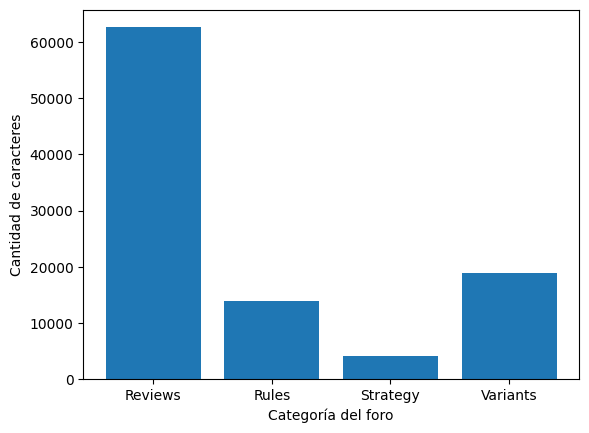

In [ ]:
plt.bar(agrupados.groups.keys(), agrupados["Conversation"].apply(lambda x: x.str.len().sum()))
plt.ylabel("Cantidad de caracteres")
plt.xlabel("Categoría del foro")
plt.show()

Vemos que la gran mayoría de texto se encuentra en la categoría de `Reviews`, seguida muy por detrás por `Variants`.
Luego `Rules` y `Strategy`, que tienen cantidades similares, a pesar de que de `Strategy` solo contamos con 6 posteos.

### Cantidad de palabras

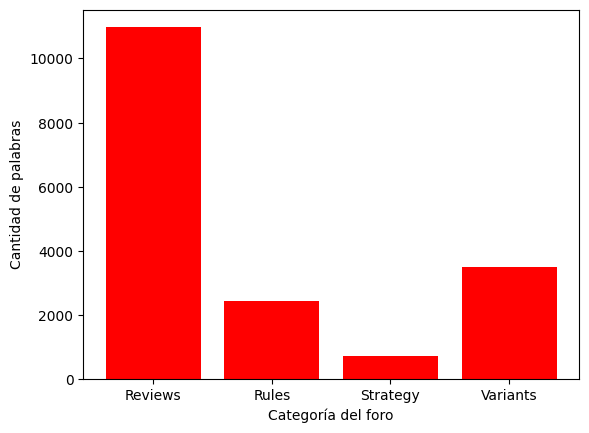

In [ ]:
plt.bar(agrupados.groups.keys(), agrupados["Conversation"].apply(lambda x:  x.str.split().str.len().sum()), color="red")
plt.ylabel("Cantidad de palabras")
plt.xlabel("Categoría del foro")
plt.show()

Como era de esperarse, la correspondencia entre cantidad de palabras y de caracteres entre las distintas categoría es clara.

## Estadísticas

In [ ]:
len(df_stats)

29

Vemos que contamos con 30 datos numéricos de distinta índole, desde precios a cantidad de interacciones en el foro.

In [ ]:
df_stats

,Title,Value
0,Avg. Rating,7.211
1,No. of Ratings,"20,747"
2,Difficulty according to the community,2.06 / 5
3,Comments,"3,037"
4,Fans,"1,019"
5,Overall Rank,462
6,Family Rank,121
7,All Time Plays,"96,528"
8,This Month,119
9,Own,"34,188"


## Manual

Veamos la longitud del manual en caracteres.

In [ ]:
len(manual)

19385

Ahora, analicemos la composición del manual.

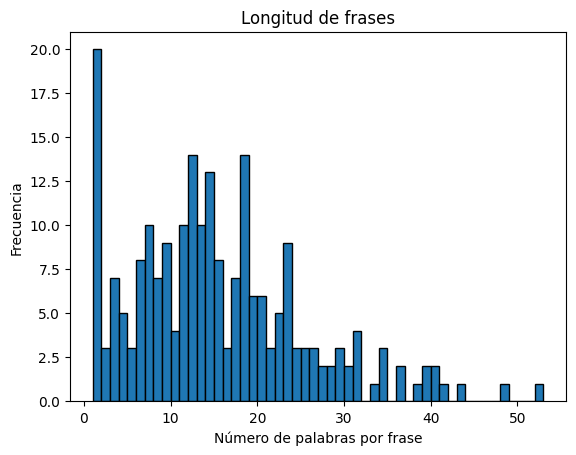

In [ ]:
# Separamos las frases
frases = re.split(r'[.!?]', manual)
# Longitud de las frases
longitudes_frases = [len(re.findall(r'\b\w+\b', frase)) for frase in frases if frase.strip()]

plt.hist(longitudes_frases, bins=range(1, max(longitudes_frases)+1), edgecolor='black')
plt.title('Longitud de frases')
plt.xlabel('Número de palabras por frase')
plt.ylabel('Frecuencia')
plt.show()

Las frases de longitud de 2-4 palabras indican que se trata de títulos o subtótulos. Es posible interpretar de este histograma entonces que existen posiblemente más de 30 títulos en el manual.

## Reseñas online

In [ ]:
len(review_bgg), len(review_externa)

(5377, 20943)

Encontramos más caracteres en la reseña externa que en el propio manual del juego, lo cual es llamativo.

## Videos

### Caracteres por video

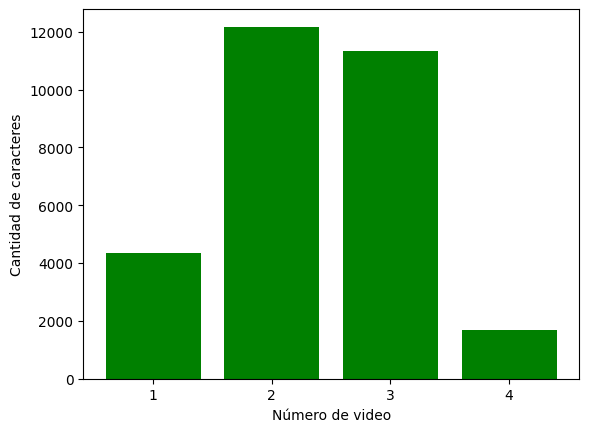

In [ ]:
plt.bar(range(1, 5), [len(video) for video in [video1, video2, video3, video4]], color="green")
plt.ylabel("Cantidad de caracteres")
plt.xlabel("Número de video")
plt.xticks([1, 2, 3, 4])
plt.show()

### Caracteres por idioma

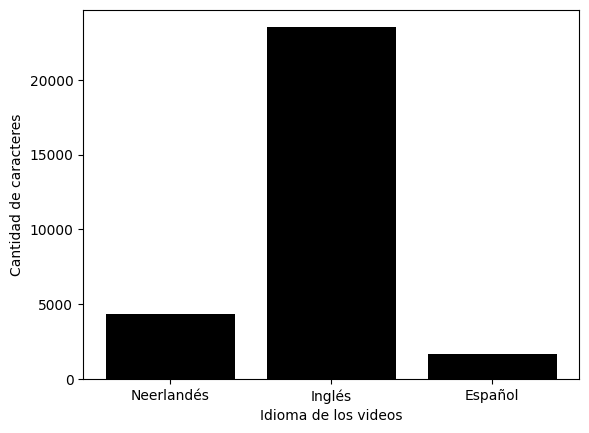

In [ ]:
totales = [len(video1), len(video2) + len(video3), len(video4)]

plt.bar(["Neerlandés", "Inglés", "Español"], totales, color="black")
plt.ylabel("Cantidad de caracteres")
plt.xlabel("Idioma de los videos")
plt.show()

Vemos que la gran mayoría del texto de los videos está en inglés

## Relaciones


In [ ]:
len(relaciones)

367

Encontramos 367 relaciones relativas al juego.

## General

Comparemos todo el texto extraído en un solo gráfico

In [ ]:
total_foro = (agrupados.groups.keys(), agrupados["Conversation"].apply(lambda x: x.str.len().sum()).sum())[1]
total_manual = len(manual)
total_reviews = len(review_bgg) + len(review_externa)
total_videos = len(video1) + len(video2) + len(video3) + len(video4)

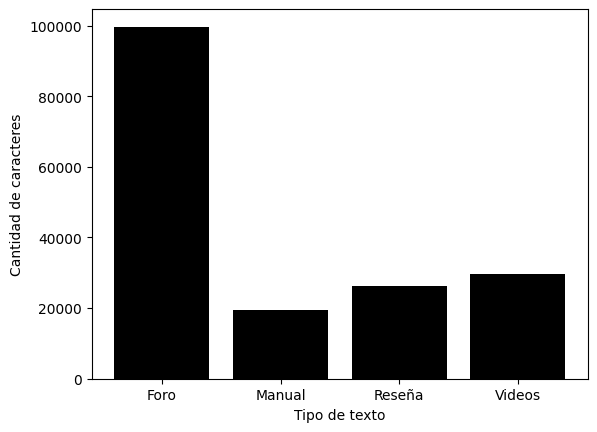

In [ ]:
plt.bar(["Foro", "Manual", "Reseña", "Videos"], [total_foro, total_manual, total_reviews, total_videos], color="black")
plt.ylabel("Cantidad de caracteres")
plt.xlabel("Tipo de texto")
plt.show()

### Cantidad de caracteres por idioma

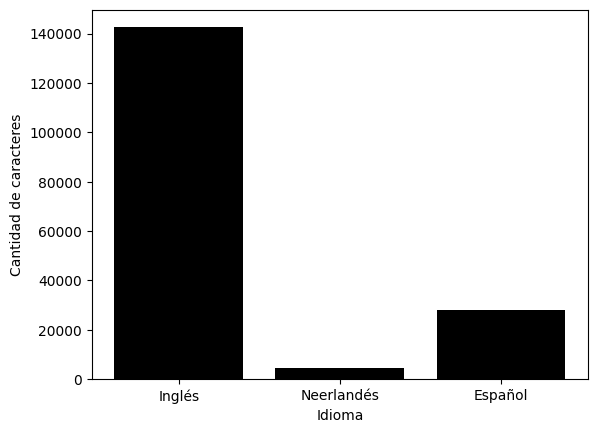

In [ ]:
# Todos los post extraídos del foro están en ingles
total_ingles = total_foro + len(video2) + len(video3) + total_manual
total_español = total_reviews + len(video4)
total_neerlandés = len(video1)

plt.bar(["Inglés", "Neerlandés", "Español"], [total_ingles, total_neerlandés, total_español], color="black")
plt.ylabel("Cantidad de caracteres")
plt.xlabel("Idioma")
plt.show()

### Relaciones y datos numéricos

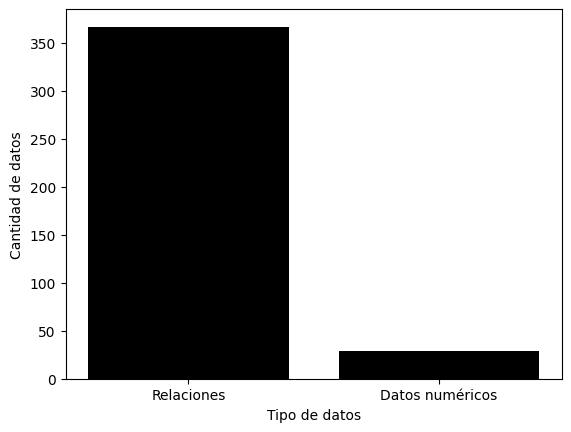

In [ ]:
plt.bar(["Relaciones", "Datos numéricos"], [len(relaciones), len(df_stats)], color="black")
plt.ylabel("Cantidad de datos")
plt.xlabel("Tipo de datos")
plt.show()

Extrajimos muchas más relaciones que datos numéricos mediante el web scraping.